# Bayesian analysis of the effects of Daylight Savings Time (DST) adjustment on the incidence rate of Acute Myocardinal Infarction (AMI)

### Background

Various papers and famous sleep researchers claim that the DST adjustment causes an increase in AMI count during the following days or weeks, attributing this increase to the reduction in sleep or the disturbance in the circadian rhythm.

### Methods

I believe this perceived increase is merely a statistical artifact resulting from low sample size and potentially publication bias, despite it being "statistically significant". This notebook investigates whether using Bayes factors with consistently and formally stated null and alternative hypotheses confirms the findings of the studies (which used frequentist hypothesis tests) and the meta-analysis (which combined the results using a "random-effect generic inverse variance approach", as described by the Cochrane Handbook).

I analyzed data from every study that was included in this meta-analysis:
 - Manfredini et al. (2019) _Daylight Saving Time and Acute Myocardial Infarction: A Meta-Analysis_. Journal of Clinical Medicine [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6463000/)
 
### Motivation

I fully acknowledge the role of adequate sleep, and I am undecided on the positive or negative effects of DST. However, I believe scientific reporting could use statistical methods that are both simpler, more explicit, less black-and-white, and more precise.

## Introduction

### How to read this article

TODO.

### Methodology shared in most papers

We refer to the week following the DST adjustment as “posttransitional week”.

Sunday, Easter

TODO

### Poisson distribution

The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event. In our case, the “event” is an AMI, and the fixed interval of time is a day. While AMIs probably don't happen at a constant rate throughout the day, the [sum of Poisson-distributed random variables](https://en.wikipedia.org/wiki/Poisson_distribution#Sums_of_Poisson-distributed_random_variables) is also Poisson-distributed, so any day's total will also be Poisson-distributed.

The distribution has a single parameter, which is a positive real number, and is often denoted $λ$. The mean (expected value) of $\text{Poisson}(λ)$ is $λ$, and the standard deviation is $\sqrt{λ}$. Its probability mass function is shown below for $λ=20$ and $λ=100$, along with an interval that covers 90% of the probability mass.

![Distribution of Poisson plots for means 20 and 100](figs/poisson-dist.svg)

If $X \sim \text{Poisson}(λ)$, meaning $X$ is a $\text{Poisson}(λ)$-distributed random variable, then the probability of $X$ having the value $k$ is

$$\mathbb P(X=k) = λ^k \frac{e^{-k}}{k!}.$$

During this re-analysis of published papers I didn’t have access to the raw data, and the papers usually reported only the sum of AMIs on a given day (e.g. Tuesday after DST change) over the period of the study (e.g. the 4 years 2010–2013). Again, the individual counts are each Poisson-distributed, so their sum is Poisson-distributed too.

## Analysis

We restrict our analysis to the AMI counts after the spring DST transition, and ignore the mean after the fall transition, and every variable related that describe patients (e.g. gender, STEMI or non-STEMI, various medications).

Instead of defining a null and alternative hypothesis and weighing the evidence against both (or only against the null hypothesis, as it is commonly done), in this article I define a model for the parameter of interest and our observations. For every paper, we have the following observations: the AMI counts on each day of the posttransitional week, and the AMI counts predicted by the trend. The unobserved parameter is the true incidence rate ratio (IRR), i.e. the multiplier by which mean AMI counts increase in the posttransitional week, compared to an average week. Our description of this parameter initially also include the reasonable uncertainty in our beliefs, quantified in the _prior distribution_. Our goal is to 

# Introduction

Sipilä2016:

> Sleep is essential for well-being and its disturbances
have been associated with disruption of numerous
physiological processes and changes in cardiovascular
risk factors (1,2). Sleep disordered breathing has been
associated with risk of coronary heart disease (3,4) and
sleep impairment with prognosis of myocardial infarction
(MI) (5).


> Daylight saving time (DST) is used in many countries
including the United States and the members of
the European Union for prolonging of sun-light
proportion of day. Clock shifts however alter and disrupt
chronobiological rhythms and impair sleep (7,8) providing
a ‘‘natural experiment’’ for studying the effects of
rhythm and sleep disruptions on the incidence of
vascular events. Although chronobiological factors
have been shown to affect the incidence of MI (9,10),
studies on the association of DST and the incidence of MI
have been partly conflicting. With one exception (11), all
studies show changes in the temporal distribution of MI
in the week following DST transitions but the patterns of
change differ (12–15) and there is no agreement about
the impact of these changes on the overall incidence of
MI (11–16).

TODO

TODO In general:
> Number of events on shorter Sunday after
transition into DST was adjusted with multiplying by 24/
23 and lengthening of Sunday after transition out of DST
with multiplying by 24/25.

What does this mean:
> Population-based incidence
of MI admissions to participating hospitals during
spring and autumn periods were calculated using
corresponding population data of mainland Finland
obtained from Statistics Finland and standardized to
European standard population 2013 by using the direct
method.

# TODO

Motto: the data is there, make good use of it while embracing uncertainty.

In the beginning I consider two competing hypotheses: the null hypothesis assumes no change in the expected AMI daily count on the week following DST adjustments. (This is what [McShane et al. (2019)](https://www.tandfonline.com/doi/full/10.1080/00031305.2018.1527253) call “the generally implausible and uninteresting sharp point null hypothesis of zero effect and zero systematic error”.) Under the alternative hypothesis, the expected AMI count increases by $+X\%$ on the following Monday, by $+0.8X\%$ on Tuesday, and so on until a $+0.2X\%$ increase on Friday. (Prior to these experiments, it feels _very_ unlikely that there would be any effect on Friday, but one paper measured effects on the 2 and 4 weeks following DST adjustment, so at least someone considered it before me.) Later we will extend the model to be the mixture of a non-zero effect in the following 1...5 weekdays instead of the fixed 5 days.

Although in the absence of data I would bet much more favorably on the null hypothesis (meaning my prior would have a much higher weight on $H_0$), in this analysis I will use 50-50% prior probabilities. Later we will see that the posterior probabilities can be easily recalculated for different priors – such as that we get from [soliciting the opinion of experts](https://www.tandfonline.com/doi/full/10.1080/00031305.2018.1518265) who haven't read this study, or that from a betting market. In the presence of large independent datasets – which humanity should have on this topic – the choice of prior doesn’t matter and is dominated by the data (under some very mild assumptions).

### Notation

For a particular study, $m_i$ denotes the AMI counts as predicted by the trend model on day $i$ (with $i = 1,\,\ldots,\,5$ for Monday, $\ldots$, Friday after the DST change), and $o_i$ denotes the observed count on day $i$. Finally, $\mathcal D$ denotes the whole dataset, i.e. all the observations $\{o_1,\ldots,o_5\}$.

### Null hypothesis

Our null hypothesis assumes that the observed count on day $i$ is sampled from a Poisson distribution with parameter $\lambda_i
$, with independent distributions for the 5 days. The likelihood of observed count $o_i$ on day $i$ is

$$\mathbb P(o_i \text{ AMIs on day } i\ |\ H_0) =
e^{-\lambda_i} \frac{\lambda_i^{o_i}}{o_i!},$$

so the likelihood of all of the data under the null hypothesis is equal to

$$\mathbb P(\mathcal D | H_0) = \prod_{i=1}^5 \mathbb P(o_i \text{ AMIs on day } i\ |\ H_0) =
\prod_{i=1}^5 e^{-\lambda_i} \frac{\lambda_i^{o_i}}{o_i!}.$$

## Alternative hypotheses

We define two alternative hypotheses: $H_1$ is that on the Monday following DST adjustment, more AMIs happen than on a regular day. Under $H_2$, the expected AMI counts increase on all days from Monday until Friday.  But by how much, specifically?

Note that the original paper did not make such estimations, because [null hypothesis significance tests](https://en.wikipedia.org/wiki/Student's_t-test#One-sample_t-test) do not require evaluating the marginal likelihood of the alternative hypothesis.

Our _prior_ expectations about the relative increase must not be defined – or even contaminated – by the actual observations; otherwise we will simply see what we want to see. We must ask: if the parameter of the Poisson distribution for day $i$ were to increase from $\lambda_i$ to $\tilde\lambda_i$, then what values could it have, and which would be more likely? (Afterwards we are going to test the assumptions we make here.) We don't expect that the new parameter is 10 times higher than the original, because we would have noticed already if 10 times more people had an infarction after a DST adjustment. A significant but plausible increase in the average AMI count would be around 20% for Monday (the first day when people need to wake up earlier), and 0% increase by Friday, expecting that the effect would taper off in a week.

Therefore, we define our prior beliefs in the alternative model about the new parameter $\tilde\lambda_1$ with a probability distribution that has support over $(\lambda_1; \inf)$, and a mean of $1.2 \lambda_1$. How do we choose the shape of the distribution? I ask my friend who's campaigning for the alternative hypothesis:

- _Me:_ “So are you saying you would be much less surprised to see a 1% increase in the AMI count on Monday (compared to the trend) than a 20% increase?”
- _Friend:_ “No, of course not, 1% is nothing. I expect around 10-30 percent.”
- _Me_: “But probably not so crazy like a +100% increase”
- _Friend_: “Right.”
- _Me_: “Thanks for your input, your expectations will be taken seriously.”

So the prior on the Monday AMI count distributes its probability mass as such:

![Prior Monday](figs/prior_monday.svg)

- _Friend_: “But hey, what about the other days?”
- _Me_: “What about them? Do you expect that the DST change would affect those too?”
- _Friend_: “Just lemme see the data and I will tell you so.”
- _Me_: “Uh-uh, it doesn’t work that way. I apologize, but humans are notorious for being easily biased, and after having seen the data you would say a hypothesis that fits it _best_. Remember, we're not looking for a single parameter, but we’re calibrating our uncertain judgements. So, how long do you expect until the effect wears off?”
- _Friend_: “For the sake of simplicity, we can assume that the effect wears off linearly, and it has no effect by Saturday, which is on the weekend anyhow.”
- _Me_: “Alright. Fortunately, the infarction counts on neighboring days are independent (apart from exceptional cases, such as a world catastrophe), which means we can model them separately and just multiply the marginal likelihoods.
($\mathrm{Pr}[\text{data} | H_1] =
\mathrm{Pr}[\text{Mon} | H_1] \,\cdot\,\ldots\,\cdot\,\mathrm{Pr}[\text{Fri} | H_1]$) The priors you described take these forms:

![Priors Monday–Friday](figs/prior_all.svg)

“Note that as the trend changes from Monday to Friday, so does the minimum of our belief about the number of infarctions. And if a distribution is narrow, it is that much taller, so for visibility we can rescale them, resulting in the following:

![Priors Monday–Friday, rescaled](figs/prior_all_rescaled.svg)

We get such a distribution if we shift a Gamma distribution by $\lambda_1$:

$$
\tilde\lambda_1 \sim \lambda_1 + \text{Gamma}(k=0.2\lambda_1,\, \theta=1)
$$

## Code

In [1]:
%load_ext autoreload
%aimport utils
%autoreload 1

In [2]:
import logging
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import utils

In [3]:
logger = logging.getLogger('BayesianScience')

logger.setLevel(logging.DEBUG)

## Data

In [4]:
data = defaultdict(lambda: {'trend': None, 'obs': None, 'num_years': None})

param_space = np.linspace(-0.2, 0.8, 1000)

log_likelihoods = defaultdict(np.ndarray)

In [5]:
EXPECTED_MONDAY_INCREASE = 0.2

def get_prior(param_space, expected_monday_increase):
    NORMAL_SCALE = 0.01 # Assume fixed stdev for now
    GAMMA_SHAPE = 1.
    
    m0 = stats.norm.pdf(param_space,
                        loc=0.,
                        scale=NORMAL_SCALE)

    m1 = stats.gamma.pdf(param_space,
                         a=GAMMA_SHAPE,
                         loc=0.,
                         scale=expected_monday_increase)

    prior = 0.5 * m0 + 0.5 * m1

    logger.debug("Total probability mass in prior: {:.3f}".format(
                    prior.sum() * utils.linspace_step(param_space)))

    return prior

prior = get_prior(param_space, EXPECTED_MONDAY_INCREASE)

# TODO: 

change param from 0. to 1.0 (and name it IRR)

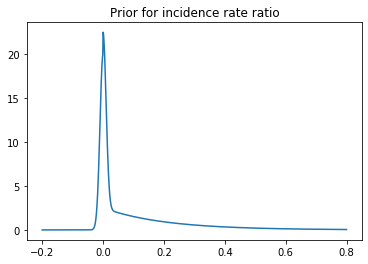

In [6]:
plt.title("Prior for incidence rate ratio")
plt.plot(param_space, prior)
plt.show()

## Sandhu et al. (2014)

Timeline: 1 January 2010 – 15 September 2013 (3 fall and 4 spring DST changes)

> Procedural data for hospital admissions where PCI was performed in the setting of AMI between 1 January 2010 and 15 September 2013 were included in this analysis.

> In this study, 42 060 hospital admissions for AMI requiring PCI occurred during the study period. Figure 1A provides a plot of the daily PCIs performed for AMI over 1354 days included in the study period. The median daily AMI total was 31, ranging from a minimum of 14 to a maximum of 53 admissions.

**Results**

> There was no difference in the total weekly number of PCIs performed for AMI for either the fall or spring time changes in the time period analysed. After adjustment for trend and seasonal effects, the Monday following spring time changes was associated with a 24% increase in daily AMI counts (p=0.011), and the Tuesday following fall changes was conversely associated with a 21% reduction (p=0.044). No other weekdays in the weeks following DST changes demonstrated significant associations.

As I was unable to obtain the data at [Blue Cross Blue Shield of Michigan](https://bmc2.org), I estimated the number of AMI cases from the chart in Figure 3. Access to data in the years since 2013 would allow me to validate the conclusions on a three times larger sample size.

Screenshot taken of figure and analyzed with [WebPlotDigitizer](https://apps.automeris.io/wpd/).

Measurement error: 1 pixel, which is $150\text{AMI}\, /\, (517-131)\text{px} ≈ 0.4$ AMIs

Figure 3 of Sandhu et al. (2014):
![Figure 3 - AMI counts after 4 years of spring DST adjustment](figs/Sandhu2014-Figure3-Spring.png)

In [7]:
ami_obs_str = """\
0.00, 108.00
1.00, 170.00
2.00, 125.33
3.00, 122.00
4.00, 116.67
5.00, 116.67
6.00, 114.00"""

ami_obs = {day: round(count)
           for day, count in zip(utils.WEEKDAYS, utils.parse_second_column(ami_obs_str)[1:6])}

In [8]:
ami_obs

{'Mon': 170, 'Tue': 125, 'Wed': 122, 'Thu': 117, 'Fri': 117}

In [9]:
ami_trend_str = """\
0.00, 111.33
1.00, 138.33
2.00, 127.67
3.00, 125.33
4.00, 120.33
5.00, 120.00
6.00, 110.33\
"""

ami_trend = utils.parse_second_column(ami_trend_str)
ami_trend = {day: count
           for day, count in zip(utils.WEEKDAYS, utils.parse_second_column(ami_trend_str)[1:6])}

In [10]:
ami_trend

{'Mon': 138.33, 'Tue': 127.67, 'Wed': 125.33, 'Thu': 120.33, 'Fri': 120.0}

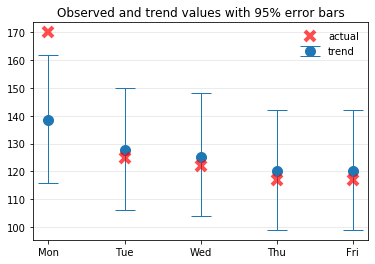

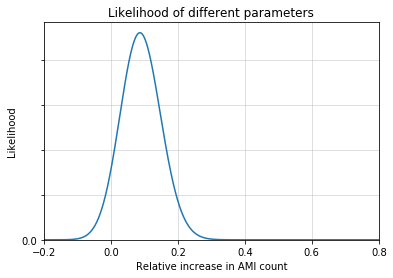

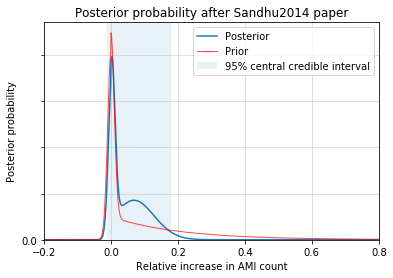

In [11]:
utils.process_study_results(data, param_space, prior, log_likelihoods,
                            "Sandhu2014", ami_trend, ami_obs, None)

# Kirchberger et al. (2015)

Kirchberger et al. 2015. _Are daylight saving time transitions associated with changes in myocardial infarction incidence? Results from the German MONICA/KORA Myocardial Infarction Registry_. BMC Public Health. 2015; 15: 778. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4535383/)

**Data**:
- AMI count: 25,499 cases of AMI
- data source: MONICA/KORA Myocardial Infarction Registry ([link](https://www.helmholtz-muenchen.de/herzschlag-info/); public data should be published yearly according to [this website](http://www.gbe-bund.de/gbe10/abrechnung.prc_abr_test_logon?p_uid=gast&p_aid=0&p_knoten=FID&p_sprache=E&p_suchstring=7014), but I did not find a link to download the dataset) 
- time period: 1 January 1985 and 31 October 2010 (26 spring and 25 fall DST changes – 2010 fall adjustment was on 31 October)
- ages: 25–74
- includes: coronary death and AMI
- location: city of Augsburg (Germany) and the two adjacent counties (about 600,000 inhabitants)
- additional variables: information on re-infarction, various medication prior to AMI, current occupation, history of hypertension, hyperlipidemia, diabetes, smoking, and obesity.
- confounders accounted for: global time trend, temperature, relative humidity, barometric pressure, and indicators for month of the year, weekday and holiday

> The final model included the following covariates: time trend and previous two day mean relative humidity as regression splines with four and two degrees of freedom, respectively, previous two day mean temperature as a linear term and day of the week as categorical variable.

> The optimized spring model [of the data from March and April, excluding the week in question] included time trend and same day mean relative humidity as regression splines with six and three degrees of freedom.

Six d.o.f. for 2 months is probably overfitting the data, even though it was the sum of 26 years. However, it shouldn’t make a predictible effect, and overall it likely had a negligible effect.

> The incidence rate ratio was assessed as observed over expected events per day and the mean per weekday and corresponding 95% confidence intervals were calculated.

However, it is not stated how the confidence intervals were calculated. It most likely wasn't a Bayesian _credible interval_ because they didn't specify the priors; so then the exact statistical test  confidence intervals would require

In [12]:
total_ami = 25_499
total_days = 9435
ami_per_day = total_ami / total_days
print("On average: {:.2f} AMI/day (stdev for the 25-year-average: {:.2f})".format(
            ami_per_day,
            stats.poisson(total_ami).std() / total_days,
            stats.poisson(ami_per_day).std()))

On average: 2.70 AMI/day (stdev for the 25-year-average: 0.02)


Assuming the researchers analyzed the data in an honest manner (i.e. not picking model parameters for lower prediction and more significant observed increase), and that the model didn't predict large deviations from the 2.7 AMI/day average, we can calculate Bayes factors using only the mean incidence ratios.

In [13]:
data_table_3_raw = """\
	Spring predicition model 	Autumn predicition model
Weekday	IRR [95 % CI]	IRR [95 % CI]
Sunday	0.937 [0.732; 1.141]	0.881 [0.667; 1.095]
Monday	1.207 [0.915; 1.500]	0.850 [0.572; 1.129]
Tuesday	1.185 [0.852; 1.519]	1.135 [0.861; 1.409]
Wednesday	1.075 [0.854; 1.297]	1.077 [0.832; 1.321]
Thursday	1.098 [0.809; 1.388]	1.133 [0.883; 1.383]
Friday	1.203 [0.950; 1.457]	1.244 [1.035; 1.453]
Saturday	0.850 [0.657; 1.043]	0.892 [0.657; 1.127]\
"""

mean_irr_spring = {}
mean_irr_autumn = {}

for line in data_table_3_raw.split('\n')[2:]:
    day_raw, spring_raw, autumn_raw = line.split('\t')
    
    day = day_raw[:3]
    f = lambda s: float(s.split(' ')[0])
    spring, autumn = map(f, (spring_raw, autumn_raw))
    mean_irr_spring[day] = spring
    mean_irr_autumn[day] = autumn

In [14]:
mean_irr_spring

{'Sun': 0.937,
 'Mon': 1.207,
 'Tue': 1.185,
 'Wed': 1.075,
 'Thu': 1.098,
 'Fri': 1.203,
 'Sat': 0.85}

Over 26 springs this adds up to:

In [15]:
num_years = 26

ami_trend = {day: ami_per_day * num_years for day in utils.WEEKDAYS}
ami_obs = {day: round(ami_trend[day] * mean_irr_spring[day]) for day in utils.WEEKDAYS}

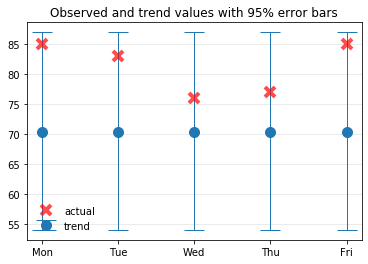

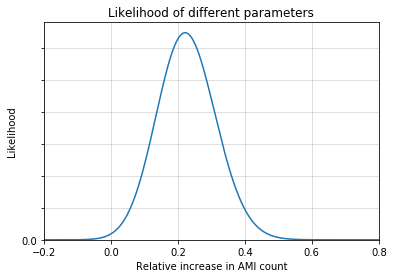

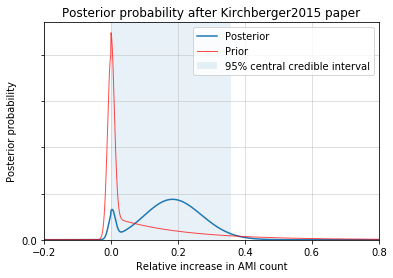

In [16]:
utils.process_study_results(data, param_space, prior, log_likelihoods,
                            "Kirchberger2015", ami_trend, ami_obs, num_years)

## Janszky and Ljung (2008)

Janszky and Ljung. 2008. _Shifts to and from Daylight Saving Time and Incidence of Myocardial Infarction_. The New England Journal of Medicine.  BMC Public Health. 359; 18. [link](https://www.nejm.org/doi/full/10.1056/NEJMc0807104)

**Data**:
 - data: from the Swedish registry of acute myocardial infarction
 - years: 1987–2006
 - observations: the incidence of AMI during each of the first 7 days after the spring or autumn transition
 - trend: the mean of the incidences on the corresponding weekdays 2 weeks before and 2 weeks after the day of interest


**Quotes**:

> The effects of transitions were consistently more pronounced for people under 65 years of age than for those 65 years of age or older.

The authors properly controlled for the Easter holiday.
> Analyses of the data for the spring shift are based on the 15 years between 1987 and
2006 in which Easter Sunday was not the transition day.
> [...]
> For years in which Easter
Sunday was celebrated 2 weeks after the Sunday of the spring shift, we defined the control period for the Sunday of
the shift as the Sunday 3 weeks before and the Sunday 3 weeks after (thus skipping Easter Sunday).

**Overanalysis**:

The following observations do not have any plausible explanation, and are probably just noise. Question: did later studies confirm these findings?

1.
> When we did
not exclude Easter if it coincided with the exposure or control days, we observed an even higher effect size associated
with the spring transition.

2.
> For the autumn shift, in contrast to the analyses of all acute myocardial infarctions, analyses restricted to fatal cases showed a smaller decrease in the incidence of acute myocardial infarction on Monday, and the risk of fatal acute myocardial infarction increased during the first week after the shift. 

3.
> The effect of the spring transition to daylight saving time on the incidence of acute myocardial infarction was somewhat more pronounced in women than in men, and the autumn effect was more pronounced in men than in women.


**Additional information**:

The authors were employed by institutions in Stockholm, Sweden, meaning there's no evidence for them picking the only dataset that supported their hypothesis.

In [17]:
data_figure_1a_raw = """\
1439/1374
1735/1636
1644/1494
1555/1471
1522/1484
1467/1422
1414/1370"""

num_years = 15

ami_obs, ami_trend = utils.parse_data(data_figure_1a_raw,
                                      utils.DAYS_OF_WEEK)

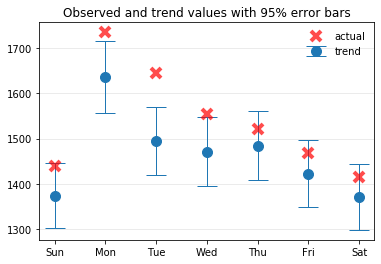

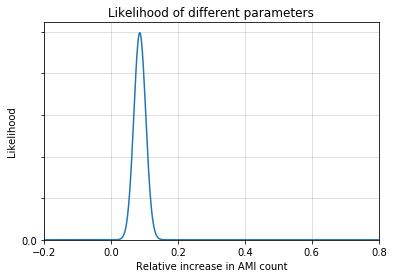

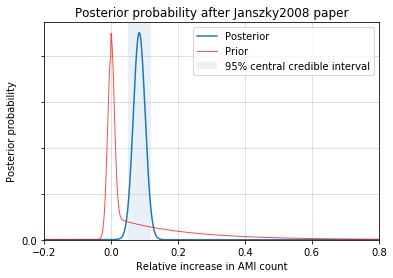

In [18]:
utils.process_study_results(data, param_space, prior, log_likelihoods,
                            "Janszky2008", ami_trend, ami_obs, num_years)

## Čulić (2013)

Viktor Čulić. 2013. _Daylight saving time transitions and acute myocardial infarction_. Chronobiology International. 2013; 30(5): 662–668. [link](https://www.tandfonline.com/doi/abs/10.3109/07420528.2013.775144)

**Data**:

- patients hospitalized because of AMI
- from 1990 to 1996
- 40 patients on workdays following DST change
- at University Hospital Centre Split in Split, Croatia

It is unclear whether the trend prediction is made from the 2 weeks before and after the posttransitional week, or from all 50 nontransitional weeks:

> The incidence ratios of AMI for the first week after the
two DST shifts (posttransitional weeks) and each day of
that week were estimated by dividing the incidence
during those periods with the average incidences during
corresponding days and weeks throughout the year: 2
wks before and 2 wks after the posttransitional week,
and the 50 nontransitional weeks of the year altogether.

It is unclear why exactly the data from 1990 to 1996 was analyzed, if the study was conducted in 2013. This is suggestive of selection bias.

**Overanalysis**:

23 additional variables were analyzed (man, woman, employed, retired, use of β-blocker, etc.); some were bound to have low p-values:

> The independent predictors for AMI during
this period in spring were male sex (p = 0.03) and nonengagement in physical activity (p = 0.02) and there was a trend
for the lower risk of incident among those taking calcium antagonists (p = 0.07). In autumn, the predictors were
female sex (p = 0.04), current employment (p = 0.006), not taking b-blocker (p = 0.03), and nonengagement in
physical activity (p = 0.02).

In [19]:
data_figure_1_raw = """\
5/6.2
14/7.2
6/6.9
9/7
6/6.2
5/6.5
8/5.9"""

num_years = 7

ami_obs, ami_trend = utils.parse_data(data_figure_1_raw,
                                      utils.DAYS_OF_WEEK)

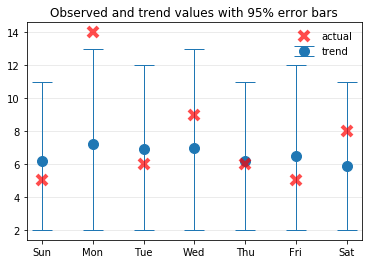

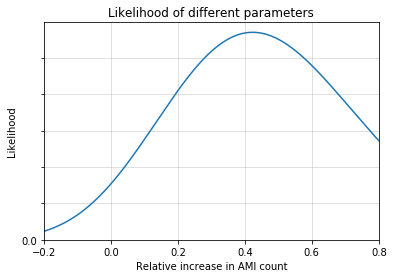

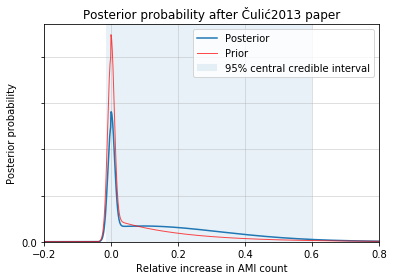

In [20]:
utils.process_study_results(data, param_space, prior, log_likelihoods,
                            "Čulić2013", ami_trend, ami_obs, num_years)

## Janszky et al. (2012)

Janszky, Ahnve, Ljung, Mukamal, Gautam, Wallentin, Stenestrand. 2012. _Daylight saving time shifts and incidence of acute myocardial infarction – Swedish Register of Information and Knowledge About Swedish Heart Intensive Care Admissions (RIKS-HIA)_. Sleep Medicine 13 (2012) 237–242. [link](https://www.sciencedirect.com/science/article/abs/pii/S1389945711003832)

**Data**:
 - those AMI patients who were admitted to CCUs at participating hospitals
 - from 1995 to 2007

This study didn't publish per-day AMI counts, only the total during the whole posttransitional week. Judging by the number of patients, this included about 50% of the Swedish population. As the time period matches exactly that of Janszky and Ljung (2008), these two results are highly correlated, and should be treated as the analysis of a subpopulation. This study doesn't add new information to the previous work with regards to the variables we consider, and as such, it is excluded from our meta-analysis.

As the authors put it:
> In a largely overlapping population, we confirmed our previous
finding that there is a short term increase in risk for AMI after
the transition into DST.

## Jiddou et al. (2013)

Monica R. Jiddou, MD, Mark Pica, BS, Judy Boura, MS, Lihua Qu, MS, and Barry A. Franklin, PhD. 2013. _Incidence of Myocardial Infarction With Shifts to and From Daylight Savings Time_. The American Journal of Cardiology. Volume 111, Issue 5, Pages 631–635. [link](http://dx.doi.org/10.1016/j.amjcard.2012.11.010)

**Data**:
- a retrospective electronic chart review
- all patients presenting to the emergency centers at Beaumont Hospitals in Royal Oak and Troy, Michigan, with the primary diagnosis of AMI
- age: patients who were aged >18 years, resulting in 70±15 years
- exclusion conditions: minor, pregnant
- from October 2006 to April 2012 (7 years)
- trend: patients admitted with comparable diagnoses on the corresponding weekdays 2 weeks before and 2 weeks after the shifts to and from DST
- additional variables: demographic data, medical history, tobacco use, prescribed medications, whether the patient underwent cardiac catheterization; diagnosis of hypertension, hyperlipidemia, and coronary artery disease.

**Methodological issues**:

1.
> 2 AMIs occurred on Easter Sunday and were considered potential confounders and excluded.

It is correct to note the incidences on Easter Sunday, but even more important would be the incidences on Easter _Monday_. But even then, is only correct to exclude the patients entirely if the relevant control incidences are also reduced.

In [21]:
data_figure_1_raw = """\
23/13.44
28/29.5
28/20.0
26/23.0
23/17.5
24/25.5
18/16.5"""

num_years = 7

trend_multiplier = 2

spring_obs, spring_trend = utils.parse_data(data_figure_1_raw,
                                      utils.DAYS_OF_WEEK)

In [22]:
data_figure_3_raw = """\
11/18.77
34/24.0
25/21.5
19/27.5
20/22.5
18/24.0
30/20.0"""

fall_obs, fall_trend = utils.parse_data(data_figure_3_raw,
                                        utils.DAYS_OF_WEEK)

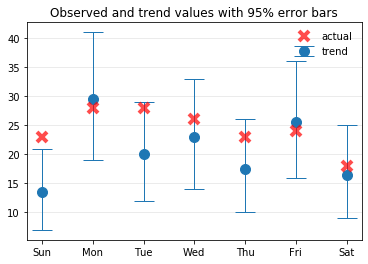

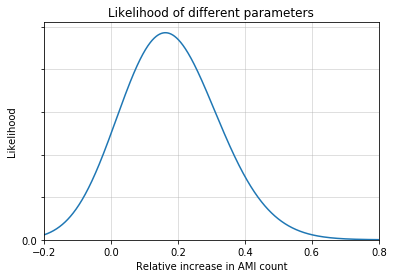

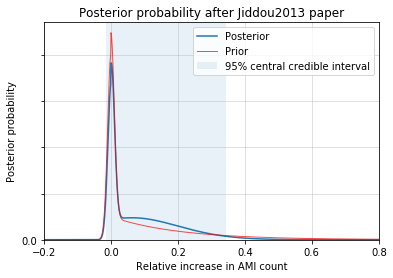

In [23]:
utils.process_study_results(data, param_space, prior, log_likelihoods,
                            "Jiddou2013", spring_trend, spring_obs, num_years)

## Sipilä et al. (2016)

Jussi O.T. Sipilä, Päivi Rautava & Ville Kytö. 2016. _Association of daylight saving time transitions with incidence and in-hospital mortality of myocardial infarction in Finland_. Annals of Medicine, 48:1-2, 10-16. [link](http://dx.doi.org/10.3109/07853890.2015.1119302)

**Data**:
 - years: 2001–2009 except 2002, 2005. 7 years.
 - Exclusion criterion: age < 18.
 - Age: mean age 71.2, SD 12.6 years
 - 2 weeks prior and 3 weeks after DST transition
 - all 22 Finnish hospitals with coronary catheterization laboratory that treat emergency cardiac patients
 - database: Finnish Care Register for Health Care (CRHC), a nationwide, obligatory and automatically collected hospital discharge database.

 - Study group: posttransitional week
 - Control group: 2 weeks before/after posttransitional week
 - Easter in study group: 2002, 2005. “Years with DST spring transition on Easter Sunday were excluded from the analysis (2002 and 2005) to increase international comparability and avoid confounding”
 - Easter in control group: “When Easter Sunday was celebrated within 2 weeks after DST transition, post-DST control weeks after Easter were selected.”
 
 - Spring study+control group size: 1269+5029 = 6298
 
 - Additional variables: TODO Appendix 1

 - Standardized incidence of MI admissions in participating hospitals during spring study period was 259/100,000 person-years.


**Noteworthy quote**:

> Incidence of MI admissions was similar to control
weeks for Sunday–Tuesday after DST transition
(Figure 1). However, on fourth day after transition
(Wednesday), there was a significant increase in MI
incidence compared to control weeks (IR 1.16; CI 1.01–
1.34).

Is there anything special about the _Wednesday_ that follows a DST transition? One should not be surprised if a value falls outside of a 95% confidence/credible interval – after all, it happens _at least_ 5% of the time even in the absence of any "interesting" effect.

**Overanalysis**:

> Patients admitted
during the week after DST transition were less likely to
have diagnosed diabetes or ventricular arrhythmias
compared to patients admitted during control weeks,
but had diagnosed renal failure more often.



In [24]:
data_figure_1_raw = """\
201/835
229/1077
253/975
254/1036
262/908
242/909
179/793"""

trend_multiplier = 4

spring_obs, spring_trend = utils.parse_data(data_figure_1_raw,
                                            utils.DAYS_OF_WEEK)

for day in spring_trend:
    spring_trend[day] /= trend_multiplier

In [25]:
data_figure_2_raw = """\
160/639
214/790
180/772
198/681
199/806
172/713
153/628
"""

fall_obs, fall_trend = utils.parse_data(data_figure_2_raw,
                                        utils.DAYS_OF_WEEK)

for day in fall_trend:
    fall_trend[day] /= trend_multiplier

Below I perform a sanity check for data input.
The difference is most likely due to the fact that patients on Easter were included in one figure but not in the other.

In [26]:
EASTER_INV_ADJUSTMENT = 9/7
SUNDAY_INV_ADJUSTMENT = 24/23
s = '{:.1f} ≈ {:.1f}'
print('Adjusted sum from Figure 1 ≈ adjusted sum from Results section')
print(s.format(sum(n if d != 'Sun' else n * SUNDAY_INV_ADJUSTMENT
                   for d,n in spring_obs.items ()),
               1269 * EASTER_INV_ADJUSTMENT))
print(s.format(sum(spring_trend.values()) * trend_multiplier,
               5029 * EASTER_INV_ADJUSTMENT))

Adjusted sum from Figure 1 ≈ adjusted sum from Results section
1628.7 ≈ 1631.6
6533.0 ≈ 6465.9


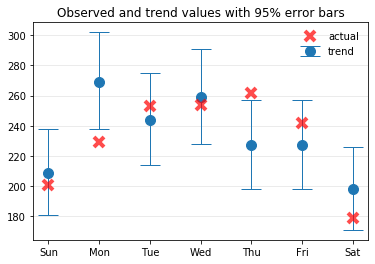

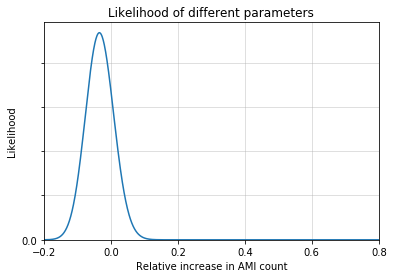

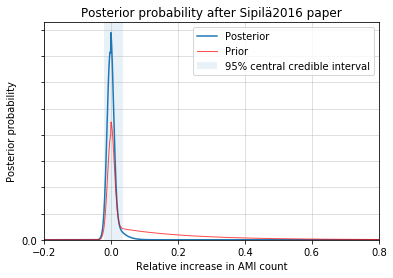

In [27]:
utils.process_study_results(data, param_space, prior, log_likelihoods,
                            "Sipilä2016", spring_trend, spring_obs, num_years)

# Test

For a short study, i.e. if the trend and observed AMI counts are low, we want to see a very slight change in the prior (i.e. a very flat likelihood); for a large study, we want to see a bigger change.

Two factors should play into this. First, if the trend predicts low counts, then we are likely to observe relatively big fluctuations. Second, if the study was short, our _estimate_ of the trend itself has greater variance. This second factor is not yet modeled in our work, but in small studies like that of Čulić (2013), this too plays a role.

For trend = obs = 1000, the posterior is even more peaked at 0.0:

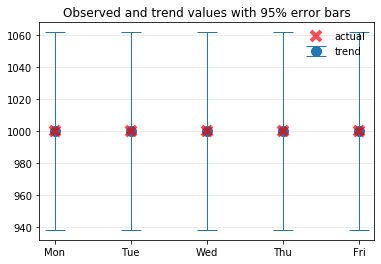

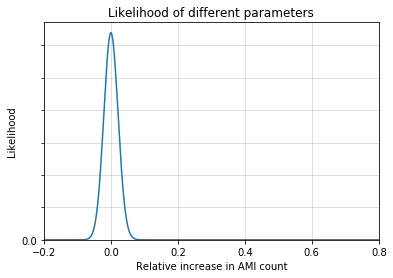

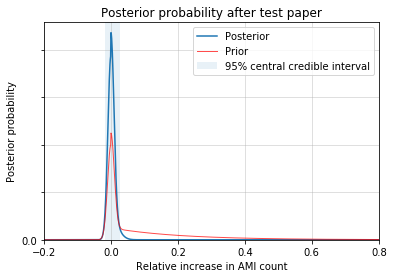

In [28]:
ami_trend = {d: 1000 for d in utils.WEEKDAYS}
ami_obs = {d: 1000 for d in utils.WEEKDAYS}

utils.process_study_results(None, param_space, prior, None,
                            "test", ami_trend, ami_obs, None,
                            plot_prior=True)

For trend = 10, obs = 11, TODO

(Note that in general it is important if third of the nonzero part of the likelihood function is off the charts, but in this case the prior is approximately zero for those values so it does not make a difference.)

In [29]:
%load_ext jupyter_spaces

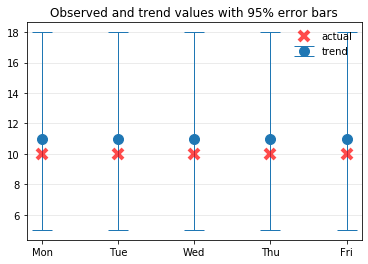

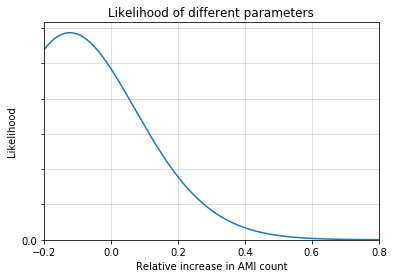

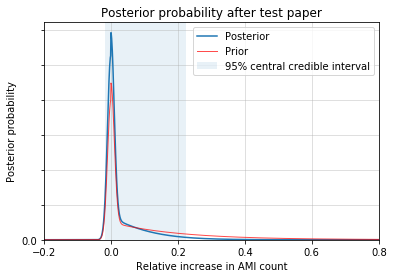

In [30]:
%%space

# extend the parameter space for this analysis:
param_space = np.linspace(-0.2, .8, 1000)
prior = get_prior(param_space, EXPECTED_MONDAY_INCREASE)

ami_trend = {d: 11 for d in utils.WEEKDAYS}
ami_obs = {d: 10 for d in utils.WEEKDAYS}

utils.process_study_results(None, param_space, prior, None,
                            "test", ami_trend, ami_obs, None,
                            plot_prior=True)

## Aggregating results from all studies

(0.04724724724724724, 0.10730730730730731)

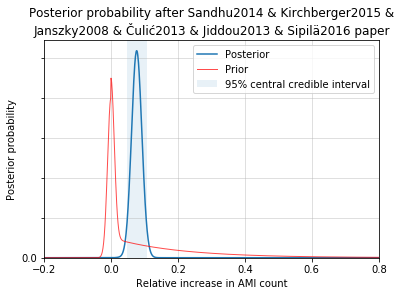

In [31]:
utils.plot_posterior(param_space, prior, log_likelihoods)

TODO: Perform a posterior predictive check – see how our model fits the observations.

## Conclusion

A standard argument against Bayesian methods is that the definition of the prior is subjective, which can have an influence on the results of the analysis. Meaningful and consistent probabilistic inference cannot be done without quantifying our initial beliefs and defining how different parameter values would result in different observations. However, in our case the observed data dominated the prior, and its prior  – all we have to assume is that .

## Calculating posterior probabilities without multiple hypotheses

In this model, we place 50-50% of the prior probability mass of either being zero effect, or there being an increase in AMI counts (under the hierarchical “Weekday Model”), where the relative increase has a weakly informative Gamma prior on it.

We calculate the likelihood of the parameter values (based on the different sets of observations), which can be easily combined with the prior: multiply the prior with the likelihood, normalize it for the parameter, and there you have your posterior.

TODO: describe the hierarchical weekday model

## Against a hypothesis test and Bayes factors

The standard practice is to define a null hypothesis as the variable of interest having some predetermined value, which in this case would correspond to zero increase in AMI counts after a DST change. In a Bayesian analysis we would need to define the alternative hypothesis as well, e.g. as some positive increase in AMI counts, with a prior probability distribution defined for this variable. This way we would put an arbitrary threshold between "interesting" and "not interesting" results: given years of data from multiple countries, the posterior probability of the alternative hypothesis would be higher than that of the null hypothesis, even if the increase is as little as 0.1%.

# References


Andrew Gelman, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin. 2013. _Bayesian Data Analysis._ [link](http://www.stat.columbia.edu/~gelman/book/)

## Further questions

**Q1.** What are the odds that there is a number of days that will have p-value less than 0.05?

The fact that every study has a separate time frame for their hypothesis, e.g. the 3/4/7/14/28 days following DST adjustment suggests that these hypotheses were made after the fact, not inspired by previous research.

Kirchberger2015:
> Overall, no significant changes of AMI risk during the first 3 days or 1 week after the transition to and from DST were found.

**Q2.** What are the odds that there will be a particular variable which makes it stick out like a sore thumb (just by random chance)? It's a function of the size of those strata: the smaller the stratum, the more likely there is an outlier. 

Kirchberger2015 (emphasis mine):
> However, subgroup analyses on the spring transition revealed significantly increased risks for men in the first 3 days after transition (RR 1.155, 95 % CI 1.000–1.334) and for persons who **took angiotensine converting enzyme (ACE) inhibitors** prior to the AMI (3 days: RR 1.489, 95 % CI 1.151–1.927; 1 week: RR 1.297, 95 % CI 1.063–1.582). After the clock shift in autumn, patients with a prior infarction had an increased risk to have a re-infarction (3 days: RR 1.319, 95 % CI 1.029–1.691; 1 week: RR 1.270, 95 % CI 1.048–1.539).

**Q3.** How are Bayes factors distributed under different values of $θ$ and N?

**Q4.** How to account for lower quality studies?

### Further points

- use highest posterior density interval instead of central credible interval
- use Bayesian decision theory, e.g. to calculate the expected number of AMIs that DST causes

## TODO
- Split into two versions: one only the facts, one the whole analysis with details.